In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fastf1 as ff1
ff1.Cache.enable_cache('../cache')

In [6]:
# Load Abu Dhabi 2023 qualifying data from Ocon and Gasly
abu_dhabi_2023_qualifying = ff1.get_event(2023, 'abudhabi').get_qualifying()

In [9]:
abu_dhabi_2023_qualifying.load()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.0.7]
req            INFO 	Using cached data for driver_info
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for

In [22]:
print('Ocon', abu_dhabi_2023_qualifying.get_driver('OCO').get(['Q1', 'Q2', 'Q3']))
print('Gasly', abu_dhabi_2023_qualifying.get_driver('GAS').get(['Q1', 'Q2', 'Q3']))

Ocon Q1    0 days 00:01:24.565000
Q2    0 days 00:01:24.391000
Q3                       NaT
Name: 31, dtype: object
Gasly Q1    0 days 00:01:24.600000
Q2    0 days 00:01:24.078000
Q3    0 days 00:01:24.548000
Name: 10, dtype: object


In [26]:
ocon_lap = abu_dhabi_2023_qualifying.laps.query('Driver == "OCO"').pick_fastest()
gasly_lap = abu_dhabi_2023_qualifying.laps.query('Driver == "GAS"').pick_fastest()

In [277]:
reference_lap = abu_dhabi_2023_qualifying.laps.pick_fastest()
reference_pos = reference_lap.get_pos_data()

# Analysing Ocon data
We need to have similar number of samples for both drivers. Firstly I see that the sample rate seems to be around every 3 tenths.

In [37]:
sampler = np.arange(0, 85, 0.3) # Sampler from 0s to 1 min 25 every 3 tenths
sampler = [pd.to_timedelta(sample, 'S') for sample in sampler]

In [88]:
ocon_pos = ocon_lap.get_pos_data()
gasly_pos = gasly_lap.get_pos_data()


oco_idx = ocon_pos.set_index(ocon_pos['Time']).index.get_indexer(sampler, method='ffill')
gas_idx = gasly_pos.set_index(gasly_pos['Time']).index.get_indexer(sampler, method='ffill')

ocon_pos = ocon_pos.loc[oco_idx]
gasly_pos = gasly_pos.loc[gas_idx]

ocon_pos = ocon_pos.set_index(ocon_pos['Time'])
ocon_pos = ocon_pos[['X', 'Y', 'Z',]]

gasly_pos = gasly_pos.set_index(gasly_pos['Time'])
gasly_pos = gasly_pos[['X', 'Y', 'Z',]]

In [156]:
""" i = 0
for (idx, pos) in ocon_pos.iterrows():
    i += 1
    x = pos['X']
    y = pos['Y']
    z = pos['Z']
    t = idx.total_seconds()

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('t = {:0.3f} seconds'.format(t))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_xlim3d([-500 + x, 1500 + x])
    ax.set_ylim3d([-1250 + y, 3375 + y])
    ax.set_zlim3d([-500 + z, 1500 + z])
    ax.set_axis_off()

    ax.plot(ocon_pos['X'], ocon_pos['Y'], ocon_pos['Z'])

    ax.plot(x, y, z, 'b-', alpha=0.3, markersize = 2, marker='.', markerfacecolor=(1, 0, 0, 1), mec='red', markevery=[-1, 0], lw=0.5)
    ax.view_init(10, -50)
    fig.savefig('./vid_img/abudhabi_follow/{:05d}.jpg'.format(int(t * 1000)), dpi=256)
    #plt.show()
    plt.close()
    print("{}of{} \r".format(t,10000), end="") """

Resample version to improve quality

In [205]:
ocon_pos_resampled = ocon_pos.resample('0.05S').mean()
ocon_pos_resampled = ocon_pos_resampled.interpolate(method='time')

gasly_pos_resampled = gasly_pos.resample('0.05S').mean().interpolate(method='time')

In [313]:
#merge ocon and gasly laps
sampler = np.arange(0, 85, 0.05) # Sampler from 0s to 1 min 25 every 0.5 tenths
sampler = [pd.to_timedelta(sample, 'S') for sample in sampler]

oco_idx = ocon_pos_resampled.index.get_indexer(sampler, method='ffill')
gas_idx = gasly_pos_resampled.index.get_indexer(sampler, method='ffill')

ocon_pos = ocon_pos_resampled.iloc[oco_idx]
gasly_pos = gasly_pos_resampled.iloc[gas_idx]

ocon_pos.reset_index(inplace=True)
gasly_pos.reset_index(inplace=True)

In [320]:
ocon_pos['Z'] = 0
gasly_pos['Z'] = 0
reference_pos['Z'] = 0

/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_36129/4268212721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ocon_pos['Z'] = 0
/var/folders/q1/q9_ky6lj68g7kv_5x5_pd9jw0000gp/T/ipykernel_36129/4268212721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gasly_pos['Z'] = 0


In [341]:
i = 0
for (idx, pos) in ocon_pos.iterrows():
    i += 1
    x = pos['X']
    y = pos['Y']
    z = pos['Z']
    t = pos['Time'].total_seconds()

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('t = {:0.3f} seconds'.format(t))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_xlim3d([-50 + x, 200 + x])
    ax.set_ylim3d([-150 + y, 400 + y])
    #ax.set_zlim3d([-100 + z, 400 + z])
    ax.set_axis_off()

    min_idx = 0 if idx - 25 < 0 else idx - 25

    ax.plot(reference_pos['X'], reference_pos['Y'], reference_pos['Z'], color='black', lw=10)

    # ocon
    ocon_trail = ocon_pos[min_idx:idx + 1]
    ax.plot(ocon_trail['X'], ocon_trail['Y'], ocon_trail['Z'], color='red', alpha=0.8)
    gasly_trail = gasly_pos[min_idx:idx + 1]
    ax.plot(gasly_trail['X'], gasly_trail['Y'], gasly_trail['Z'], color='deepskyblue', alpha=0.8)
    
    ax.plot(x, y, z, alpha=1, markersize = 6, marker='.', color='red')
    # gasly
    x_2 = gasly_pos.loc[idx]['X']
    y_2 = gasly_pos.loc[idx]['Y']
    z_2 = gasly_pos.loc[idx]['Z']
    #ax.plot(gasly_pos['X'], gasly_pos['Y'], gasly_pos['Z'], color='cornflowerblue')
    ax.plot(x_2, y_2, z_2, alpha=1, markersize = 6, marker='.', color='deepskyblue')


    #ax.view_init(10, -10)
    fig.savefig('./vid_img/abudhabi_follow_resampled/{:05d}.jpg'.format(int(t * 1000)), dpi=256)
    #plt.show()
    plt.close()
    print("{}of{} \r".format(t,10000), end="")
    #if i > 10:
    #    break

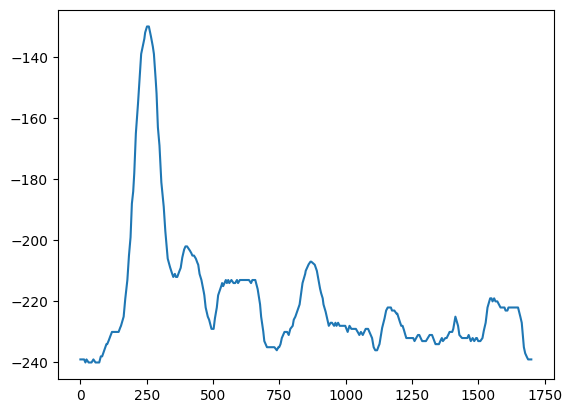

In [308]:
ax = plt.subplot()
ax.plot(ocon_pos['Z'])

In [178]:
import os

# Get all files in the current directory
files = os.listdir('./vid_img/abudhabi_follow_resampled/')

# Filter for .jpg files
jpg_files = [f for f in files if f.endswith('.jpg')]

# Sort the files to ensure order
jpg_files.sort()

# Path for the output file
output_file_path = './vid_img/abudhabi_follow_resampled/file_list.txt'

# Write the file paths to the output file
with open(output_file_path, 'w') as output_file:
    for jpg_file in jpg_files:
        output_file.write(f"file '{jpg_file}'\n")

output_file_path

'./vid_img/abudhabi_follow_resampled/file_list.txt'

In [189]:
print('framerate -> ', round(1 / (ocon_lap['LapTime'] / len(ocon_pos_resampled)).total_seconds()))

framerate ->  20
